In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import glob
from scipy.stats import f_oneway, kruskal
plt.rcParams['figure.figsize'] = (3.2, 2.8)
%matplotlib inline

In [7]:
fList = glob.glob('./flightData/*.csv')
dfList = []
for idx,file in enumerate(fList):
    currDF = pd.read_csv(file)
    dfList.append(currDF)
    
df_flights = pd.concat(dfList)
df_flights.drop(df_flights.columns[-1], axis=1, inplace=True)

### Clean up - look at flights from major airports, remove outliers

In [8]:
minFlights = 1000
count = df_flights[['ORIGIN_AIRPORT_ID','MONTH']].groupby('ORIGIN_AIRPORT_ID').count()
bigAirports = count[count['MONTH']>minFlights].index
allAirports = count.index

print(len(bigAirports)/len(allAirports))
print(count['MONTH'][count['MONTH']>minFlights].sum()/count['MONTH'].sum())

df_flights = df_flights[(df_flights['ORIGIN_AIRPORT_ID'].isin(bigAirports)) &
                 (df_flights['DEST_AIRPORT_ID'].isin(bigAirports))]


0.7384615384615385
0.9917327212172354


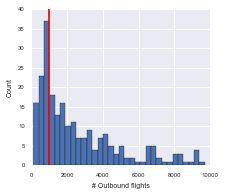

In [91]:
fig = plt.figure(figsize=(3.2, 2.8))
count['MONTH'].hist(bins=range(100,10000,300))
plt.axvline(minFlights, color='red')
plt.xlabel('# Outbound flights',fontsize=7)
plt.ylabel('Count',fontsize=7)
ax = plt.gca()
ax.tick_params(labelsize = 6)
plt.savefig('outboundFlightDist.png',dpi=300)

In [17]:
goodEntries = ((df_flights['ARR_DELAY'] - df_flights['ARR_DELAY'].mean())/df_flights['ARR_DELAY'].std() < 6)
df_flights = df_flights[goodEntries]
df_flights.head()

,MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST_STATE_ABR,DEP_DELAY,DEP_TIME_BLK,ARR_DELAY,DISTANCE,WEATHER_DELAY
0,4,2,12478,NY,12892,CA,-6,0900-0959,2,2475,NaN
1,4,3,12478,NY,12892,CA,-7,0900-0959,10,2475,NaN
2,4,4,12478,NY,12892,CA,-4,0900-0959,-12,2475,NaN
3,4,5,12478,NY,12892,CA,-3,0900-0959,14,2475,NaN
4,4,6,12478,NY,12892,CA,-6,0900-0959,5,2475,NaN


In [22]:
df_airports = pd.read_csv('L_AIRPORT_ID.csv')
df_airports.head()

,Code,Description
0,10001,"Afognak Lake, AK: Afognak Lake Airport"
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10004,"Lik, AK: Lik Mining Camp"
3,10005,"Little Squaw, AK: Little Squaw Airport"
4,10006,"Kizhuyak, AK: Kizhuyak Bay"


### Plot distribution of weather delays and manmade delays

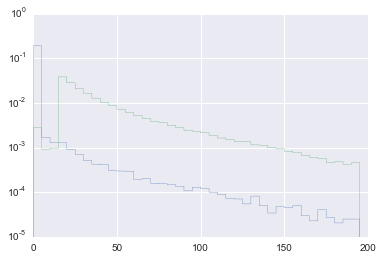

In [101]:
tmp = df_flights.dropna()
bins = range(0,200,5)
plt.hist(tmp['WEATHER_DELAY'].values, bins=bins, normed=True, histtype='step')
plt.hist((tmp['ARR_DELAY'] - tmp['WEATHER_DELAY']).values, bins=bins, normed=True, histtype='step')
plt.xlim(0,200)
plt.yscale('log')

In [103]:
tmp = df_flights[['WEATHER_DELAY','ARR_DELAY']].dropna()
(tmp['WEATHER_DELAY']/tmp['ARR_DELAY']).mean()

0.027111083785502695

### Do delays depend more on origin or destination?

In [18]:
values_by_origin = [col for col_name, col in 
                    df_flights[['ARR_DELAY', 'ORIGIN_AIRPORT_ID']].dropna().groupby('ORIGIN_AIRPORT_ID')['ARR_DELAY']]
values_by_dest = [col for col_name, col in 
                    df_flights[['ARR_DELAY', 'DEST_AIRPORT_ID']].dropna().groupby('DEST_AIRPORT_ID')['ARR_DELAY']]
print(f_oneway(*values_by_origin))
print(f_oneway(*values_by_dest))
# kruskal(*values_by_dest)

F_onewayResult(statistic=267.48269541286322, pvalue=0.0)
F_onewayResult(statistic=207.58919313349023, pvalue=0.0)


In [19]:
import anova
print(anova.EffectSize(*values_by_origin))
print(anova.EffectSize(*values_by_dest))

0.01134733389758583
0.008828923679047246


### Plot delays as function of flight distance

In [20]:
binSize = 100
bins = np.arange(0,2500,binSize)
meanDEP = np.zeros(bins.shape)
semDEP = np.zeros(bins.shape)
varDEP = np.zeros(bins.shape)
meanARR = np.zeros(bins.shape)
semARR = np.zeros(bins.shape)
varARR = np.zeros(bins.shape)

for ind,left in enumerate(bins):
    currDatARR = df_flights['ARR_DELAY'][(df_flights['DISTANCE']>=left) & (df_flights['DISTANCE']<left+binSize)]
    meanARR[ind] = currDatARR.mean()
    semARR[ind] = currDatARR.std()/np.sqrt(len(currDatARR))
    varARR[ind] = currDatARR.var()
    
    currDatDEP = df_flights['DEP_DELAY'][(df_flights['DISTANCE']>=left) & (df_flights['DISTANCE']<left+binSize)]
    meanDEP[ind] = currDatDEP.mean()
    semDEP[ind] = currDatDEP.std()/np.sqrt(len(currDatDEP))
    varDEP[ind] = currDatDEP.var()

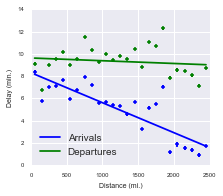

In [76]:
x = bins + binSize/2
yARR = sm.WLS(meanARR,sm.add_constant(x),weights = 1/varARR).fit().predict()
yDEP = sm.WLS(meanDEP,sm.add_constant(x),weights = 1/varDEP).fit().predict()

fig = plt.figure(figsize=(3.2, 2.8))
ax = fig.add_subplot(111)
ax.errorbar(x,meanARR,yerr=semARR,fmt='b.')
ax.plot(x,yARR,'b',label='Arrivals')
ax.errorbar(x,meanDEP,yerr=semDEP,fmt='g.')
ax.plot(x,yDEP,'g',label='Departures')
ax.set_xlabel('Distance (mi.)',fontsize=7)
ax.set_ylabel('Delay (min.)',fontsize=7)
ax.tick_params(labelsize = 6)
plt.legend(loc='lower left')
plt.savefig('delayVsDist.png',dpi=300)

In [27]:
#there is no significant correlation with departures (with arrivals it's highly significant)
tmp1 = sm.WLS(meanDEP,sm.add_constant(x),weights = 1/varDEP).fit()
tmp2 = sm.WLS(meanARR,sm.add_constant(x),weights = 1/varARR).fit()

In [105]:
tmp1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Model:                            WLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.4745
Date:                Tue, 20 Oct 2015   Prob (F-statistic):              0.498
Time:                        16:54:05   Log-Likelihood:                -41.029
No. Observations:                  25   AIC:                             86.06
Df Residuals:                      23   BIC:                             88.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          9.6286      0.532     18.102      0.000         8.528    10.729
x1            -0.0002      0.000     -0.689      0.498        -0.001     0.000
==============================================================================
Omnibus:                        1.026   Durbin-Watson:                   1.417
Prob(Omnibus):                  0.599   Jarque-Bera (JB):                0.168
Skew:                          -0.010   Prob(JB):                        0.919
Kurtosis:                       3.401   Cond. No.                     3.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Plot map of average delay by state

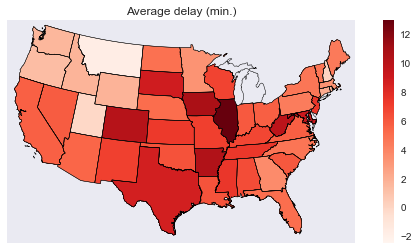

In [96]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

avgDelay = df_flights[['ARR_DELAY','ORIGIN_STATE_ABR']].groupby('ORIGIN_STATE_ABR').mean()

fig = plt.figure(figsize=(10.0, 4.0))
ax = fig.add_subplot(111)
ax.set_title("Average delay (min.)")
# create the map
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# load the shapefile, use the name 'states'
map.readshapefile('states', name='states', drawbounds=True)

# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_abbr = []
for shape_dict in map.states_info:
    state_abbr.append(shape_dict['STATE_ABBR'])

patches = []
col = [];
for state in state_abbr:
    ind = avgDelay.index==state
    if not(any(ind)):
        continue
    seg = map.states[state_abbr.index(state)]
    currVal = avgDelay[ind]['ARR_DELAY'].values[0]
    col.append(currVal)
    poly = Polygon(seg,edgecolor='black')
    patches.append(poly)
    
p = PatchCollection(patches, cmap=plt.get_cmap('Reds'))
p.set_array(np.array(col))
ax.add_collection(p)
plt.colorbar(ax.get_children()[3], ax = ax)

### Now only weather delays

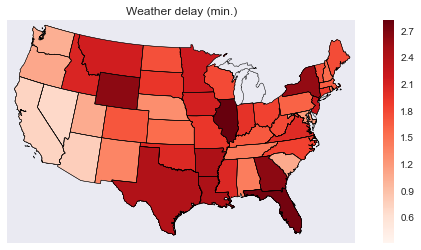

In [34]:
avgDelayW = df_flights[['WEATHER_DELAY','ORIGIN_STATE_ABR']].groupby('ORIGIN_STATE_ABR').mean()
avgDelayW.fillna(0,inplace=True)

fig = plt.figure(figsize=(10.0, 4.0))
ax = fig.add_subplot(111)
ax.set_title("Weather delay (min.)")
# create the map
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# load the shapefile, use the name 'states'
map.readshapefile('states', name='states', drawbounds=True)

# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_abbr = []
for shape_dict in map.states_info:
    state_abbr.append(shape_dict['STATE_ABBR'])

patches = []
col = [];
for state in state_abbr:
    ind = avgDelayW.index==state
    if not(any(ind)):
        continue
    seg = map.states[state_abbr.index(state)]
    currVal = avgDelayW[ind]['WEATHER_DELAY'].values[0]
    col.append(currVal)
    poly = Polygon(seg,edgecolor='black')
    patches.append(poly)
    
p = PatchCollection(patches, cmap=plt.get_cmap('Reds'))
p.set_array(np.array(col))
ax.add_collection(p)
plt.colorbar(ax.get_children()[3], ax = ax)
plt.savefig('weatherDelayMap.png',dpi=300)

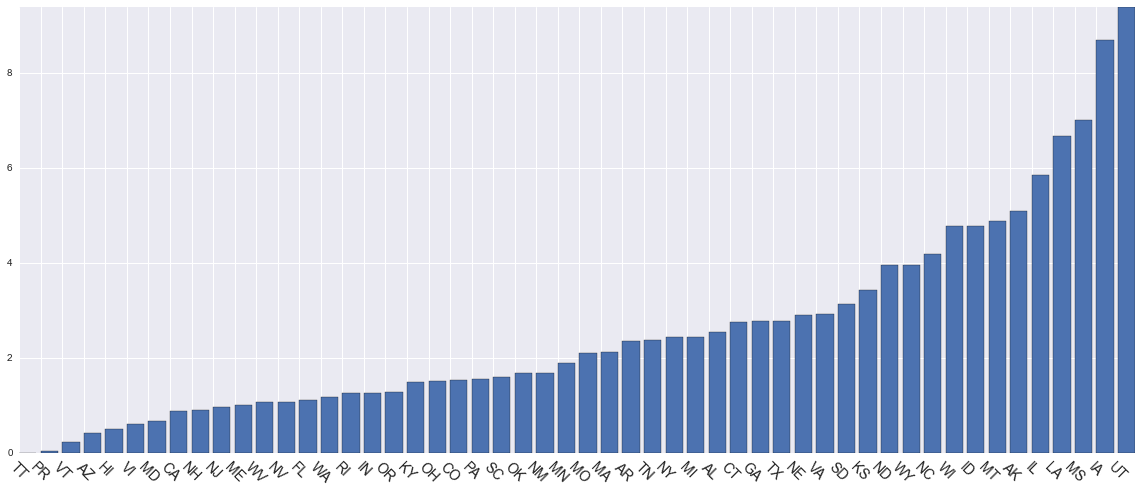

In [171]:
fig = plt.figure(figsize=(20.0, 8.0))
avgDelayW.sort('WEATHER_DELAY',inplace=True)
x = range(len(avgDelay))
plt.bar(x,avgDelayW['WEATHER_DELAY'])
ticks = plt.xticks(x,avgDelayW.index,rotation=-45)
for tick in ticks[0]:
    tick.label.set_fontsize(14)

plt.autoscale(tight='True')
plt.xlabel('State')
plt.ylabel('Average weather delay (min.)')

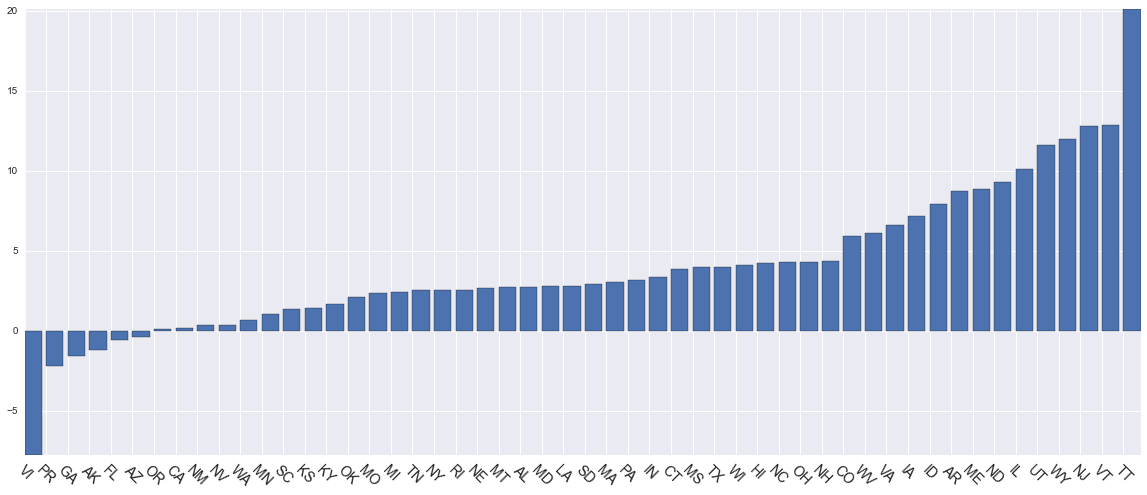

In [170]:
fig = plt.figure(figsize=(20.0, 8.0))
avgDelay.sort('ARR_DELAY',inplace=True)
x = range(len(avgDelay))
plt.bar(x,avgDelay['ARR_DELAY'])
ticks = plt.xticks(x,avgDelay.index,rotation=-45)
for tick in ticks[0]:
    tick.label.set_fontsize(14)

plt.autoscale(tight='True')
plt.xlabel('State')
plt.ylabel('Average delay (min.)')

### Plot difference between inbound and outbound flights

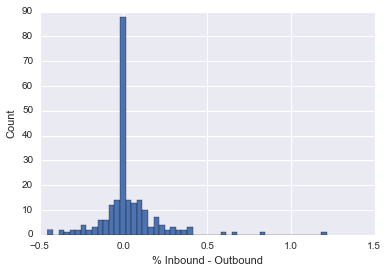

In [214]:
inbound = df_flights[['MONTH','DEST_AIRPORT_ID']].groupby('DEST_AIRPORT_ID').count()
outbound = df_flights[['MONTH','ORIGIN_AIRPORT_ID']].groupby('ORIGIN_AIRPORT_ID').count()
inbound.sort_index(inplace=True)
outbound.sort_index(inplace=True)
diff = 100*(inbound-outbound)/(inbound+outbound)
diff = diff[inbound['MONTH']>100]
x = plt.hist(diff['MONTH'].values, bins=50)
plt.xlabel('% Inbound - Outbound')
plt.ylabel('Count')
# sns.kdeplot(diff['MONTH'])

### Plot delay as a function of time on weekdays

/Users/eladg/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(-100, 100)

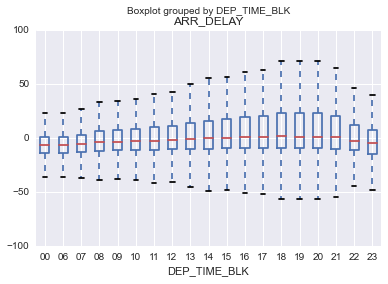

In [35]:
weekdays = df_flights[df_flights['DAY_OF_WEEK']<6];
weekdays['DEP_TIME_BLK'] = weekdays['DEP_TIME_BLK'].map(lambda x: x[0:2])
arrDelay = weekdays[['ARR_DELAY','DEP_TIME_BLK']].groupby('DEP_TIME_BLK').mean()
weekdays.boxplot(column='ARR_DELAY', by='DEP_TIME_BLK')
# sns.boxplot(data=weekdays, x='DEP_TIME_BLK', y='ARR_DELAY')
plt.ylim(-100,100)

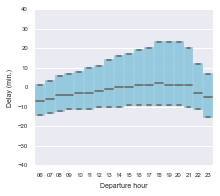

In [43]:
fig = plt.figure(figsize=(3.2, 2.8))
sns.boxplot(data=weekdays.sort('DEP_TIME_BLK'), x='DEP_TIME_BLK', y='ARR_DELAY', whis = 0, fliersize = 0,\
            color='skyblue')
plt.ylim(-40,40)
plt.xlim(0.5,18.5)
plt.xlabel('Departure hour',fontsize=7)
plt.ylabel('Delay (min.)',fontsize=7)
ax = plt.gca()
ax.tick_params(labelsize = 6)
plt.savefig('flightDelayByHourBox.png',dpi=300)

### Load Taxi data

In [44]:
import datetime

# useful func
def zscore(x):
    return (x - (x.astype(float)).mean())/(x.astype(float)).std()

# in order to calculate distance between points using coordinates
from math import radians, cos, sin, asin, sqrt

def haversine(coords1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    lon1, lat1 = coords1
#     lon2, lat2 = coords2
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth 6371 for kilometers. 3956 for miles
    return c * r

# define function to calculate distance from JFK
def distFromJFK(coords):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # JFK coordinates
    latJFK = 40.6397
    lonJFK = -73.7789
    
#     return np.sqrt((lonJFK - coords[0])**2 + (latJFK - coords[1])**2)
    return haversine((lonJFK, latJFK), coords[0], coords[1])

In [45]:
fList = glob.glob('/Users/eladg/Documents/Git/NYC_Data_IPA/Taxi/allTaxiData*.pkl')
fListDist = glob.glob('/Users/eladg/Documents/Git/NYC_Data_IPA/Taxi/dJFK*.pkl')
dfList = []
distList = []
testList = ['trip_time_in_secs', 'trip_distance', 'dropoff_latitude', 'dropoff_longitude'] # list of columns to test
for idx,file in enumerate(fList):
    currDF = pd.read_pickle(file)
    currDist = pd.read_pickle(fListDist[idx])
#     currDist = currDF[['dropoff_longitude', 'dropoff_latitude']].apply(distFromJFK,axis=1)
    
    # clean the data during the loading procedure to keep memory cost low
    goodEntries = (currDF[testList] != 0).all(axis=1) &\
    (currDF[testList] < np.inf).all(axis=1)
    currDF = currDF[goodEntries]
    currDist = currDist[goodEntries]
    goodEntries2 = (currDF[testList].apply(zscore) < 10).all(axis=1)
    currDF = currDF[goodEntries2]
    currDist = currDist[goodEntries2]
    dfList.append(currDF)
    distList.append(currDist)
#     if idx>0:
#         break
    
df = pd.concat(dfList)
dJFK = pd.concat(distList)

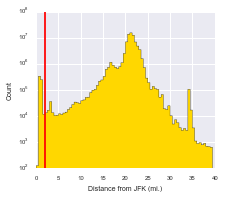

In [108]:
fig = plt.figure(figsize=(3.2, 2.8))
dJFK.hist(bins=np.arange(0,40,0.5),color='gold',histtype='stepfilled')
plt.yscale('log')
plt.axvline(2, color='red')
plt.xlabel('Distance from JFK (mi.)',fontsize=7)
plt.ylabel('Count',fontsize=7)
ax = plt.gca()
ax.tick_params(labelsize = 6)
plt.savefig('distanceFromJFK_hist.png', dpi=300)

In [66]:
tripsToAirport = dJFK < 2
dfAirport = df[tripsToAirport]
dateDur = dfAirport[['pickup_date', 'trip_time_in_secs']]
dfAirport['hour'] = dateDur.apply(lambda x: np.floor((x['pickup_date'] +
                                                  datetime.timedelta(0,x['trip_time_in_secs'])).hour % 24), axis=1)
day = np.arange(0,5)
location = (-73.994599,40.739668)
distFromLoc = dfAirport[['pickup_longitude', 'pickup_latitude']].apply(haversine, args=location, axis=1)
tripTimes = dfAirport[['trip_time_in_secs','hour']][(dfAirport['pickup_day_of_week'].isin(day)) &\
                                           (distFromLoc < 0.3)]
tripTimes['trip_time_in_secs'] = tripTimes['trip_time_in_secs']/60

/Users/eladg/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


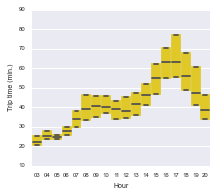

In [131]:
fig = plt.figure(figsize=(3.2, 2.8))
tripTimes['hour'] = tripTimes['hour'].astype(int).astype('str').apply(str.zfill,args=(2,))
sns.boxplot(data=tripTimes.sort('hour'), x='hour', y='trip_time_in_secs', whis = 0, fliersize = 0,\
            color = '#fedf08')
plt.xlabel('Hour',fontsize=7)
plt.ylabel('Trip time (min.)',fontsize=7)
ax = plt.gca()
ax.tick_params(labelsize = 6)
plt.xlim(2.5,20.5)
plt.ylim(10,90)
plt.savefig('taxiDurationByHourBox.png',dpi=300)

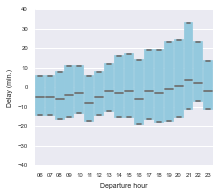

In [70]:
fig = plt.figure(figsize=(3.2, 2.8))
jfkFlights = weekdays[weekdays['ORIGIN_AIRPORT_ID']==12478]
sns.boxplot(data=jfkFlights.sort('DEP_TIME_BLK'), x='DEP_TIME_BLK', y='ARR_DELAY', whis = 0, fliersize = 0,\
            color='skyblue')
plt.ylim(-40,40)
plt.xlim(0.5,18.5)
plt.xlabel('Departure hour',fontsize=7)
plt.ylabel('Delay (min.)',fontsize=7)
ax = plt.gca()
ax.tick_params(labelsize = 6)
# lgd = plt.legend()
# lgd.set_visible(False)
plt.savefig('jfkDelays.png',dpi=300)

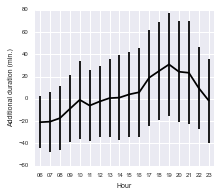

In [109]:
grp = tripTimes.groupby('hour')
taxiAvg = grp.mean() - tripTimes['trip_time_in_secs'].mean()
taxiVar = grp.var()
taxi = taxiAvg.join(taxiVar, lsuffix='_avg', rsuffix='_var').reset_index()
taxi['hour'] = (taxi['hour'].astype(int) + 2)%24

grp = jfkFlights[['ARR_DELAY', 'DEP_TIME_BLK']].groupby('DEP_TIME_BLK')
flightAvg = grp.mean()
flightVar = grp.var()
flight = flightAvg.join(flightVar, lsuffix='_avg', rsuffix='_var').reset_index()
flight.rename(columns={'DEP_TIME_BLK':'hour'}, inplace=True)
flight['hour'] = flight['hour'].astype(int)
flight

joint = pd.merge(taxi,flight, on='hour')
joint['totalTime'] = joint['trip_time_in_secs_avg'] + joint['ARR_DELAY_avg']
joint['totalVar'] = np.sqrt(joint['trip_time_in_secs_var'] + joint['ARR_DELAY_var'])

chosen = (joint['hour']>=6) & (joint['hour']<=23)
x = joint['hour'][chosen].astype('str').apply(str.zfill,args=(2,))
fig = plt.figure(figsize=(3.2, 2.8))
plt.errorbar(x,joint['totalTime'][chosen], yerr = joint['totalVar'][chosen], color='black')
plt.xlim(5.5,23.5)
plt.xticks(range(6,24),x)
plt.xlabel('Hour',fontsize=7)
plt.ylabel('Additional duration (min.)',fontsize=7)
ax = plt.gca()
ax.tick_params(labelsize = 6)
plt.savefig('flight+Taxi.png',dpi=300)

### Calculate probability of long delays

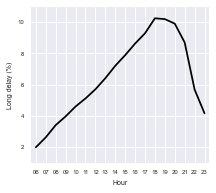

In [110]:
longDelays = weekdays[['ARR_DELAY','DEP_TIME_BLK']][weekdays['ARR_DELAY']>60]\
.groupby('DEP_TIME_BLK').count('ARR_DELAY')

totalDelays = weekdays[['ARR_DELAY','DEP_TIME_BLK']]\
.groupby('DEP_TIME_BLK').count('ARR_DELAY')

pLong = longDelays/totalDelays
pLong.reset_index(inplace=True)
pLong = pLong.ix[1:,:]
x = pLong['DEP_TIME_BLK']

fig = plt.figure(figsize=(3.2, 2.8))
plt.plot(x.astype(int),pLong['ARR_DELAY']*100, color='black')
plt.xlim(5.5,23.5)
plt.xticks(range(6,24),x.values)
plt.xlabel('Hour',fontsize=7)
plt.ylabel('Long delay (%)',fontsize=7)
ax = plt.gca()
ax.tick_params(labelsize = 6)
plt.savefig('longDelayProb.png',dpi=300)

In [138]:
df_flights['ARR_DELAY'].max()

242.0